### Moving Average Process

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [56]:
df = pd.read_csv('./widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


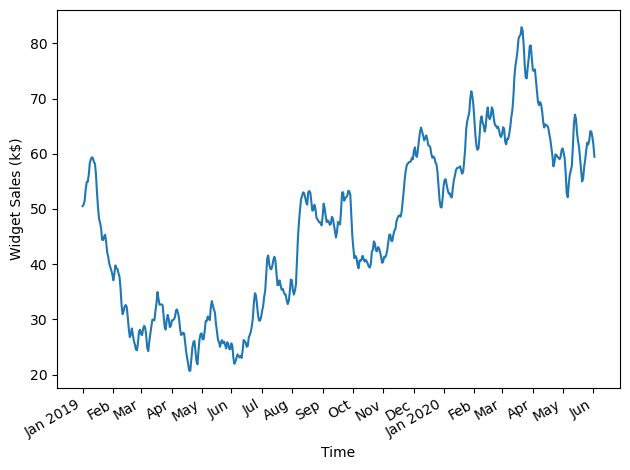

In [57]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [58]:
### Test for stationary - ADF test
ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


p-value > 0.05; as a result, our time series is not stationary.

In [59]:
#conver the series to stationary using diff method
widget_sales_diff = np.diff(df['widget_sales'], n=1)

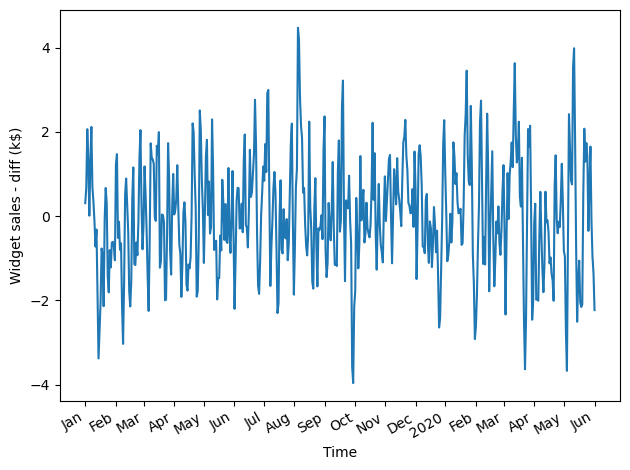

In [60]:
# plot differenced series
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


We can see that we successfully removed the
long-term trend component of our series, as values are hovering around 0 over the
entire period.

In [61]:
#Testing ADF again
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


Now, our series is stationary since our P-values < 0.05

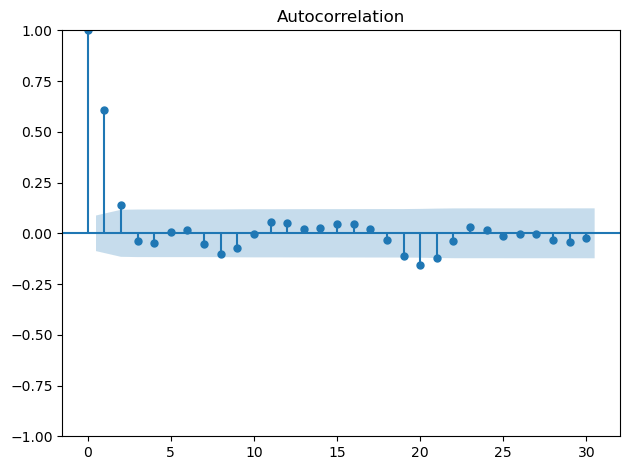

In [62]:
#Ploting autocorrelation ACF
plot_acf(widget_sales_diff, lags=30)
plt.tight_layout()
plt.show()

Notice how the coefficients are
significant up until lag 2, and then they fall abruptly into the non-significance zone
(shaded area) of the plot. 

### Forecasting a MA(2) process


In [63]:
#Split our series
df_diff = pd.DataFrame({'widget_sales_diff' : widget_sales_diff})

#Allocate 90% to the train
train = df_diff[:int(0.9 * len(df_diff))]

#Reserve 10% to the test
test = df_diff[int(0.9 * len(df_diff)) : ]

print(len(train))
print(len(test))

449
50


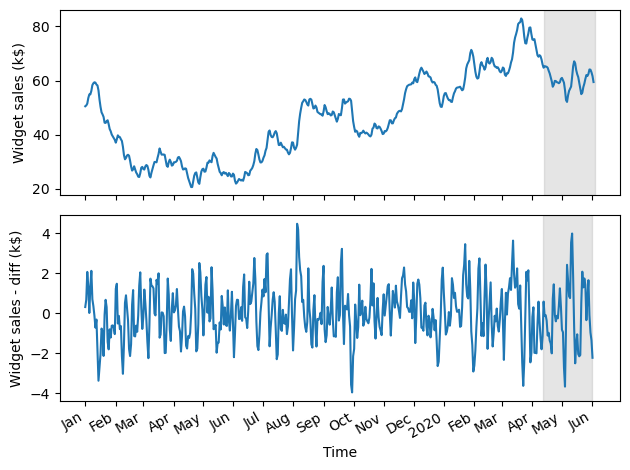

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)


ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

Forecasting period for the original and differenced series. Remember that
our differenced series has one less data point than in its original state.

### Forecasting using the MA(Q) model

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# rolling forecast: parte con train len y predice en bloque (window) hasta completar Horizon

#Train len: Cuantas observaciones usas para el primer entrenamiento
#horizon: Cuantos pasos en el futuro quieres en total(example: 50)
#window: Cuantos pasos predices en cada iteracion(example: 2)

def rolling_forecast(df: pd.DataFrame, train_len : int, horizon: int, window: int, method:str) -> list:
    # total_len : Limite hasta donde queremos llegar     
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []


        for i in range(train_len, total_len, window):
            #calcula la media de toda la serie hasta el indice i
            mean = np.mean(df[:i].values)
            #añade esa misma media (widow) veces y repite hasta alcanzar el horizonte
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            #Toma el utlimo valor observado dentro de la ventana de entramiento
            last_value = df[:i].iloc[-1].values[0]
            # Repite ese mismo valor (window) veces
            pred_last_value.extend(last_value for _ in range(window))
        
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            # Ajuste un MA(2)
            model = SARIMAX(df[:i], order=(0,0,2))
            # Ajuste el modelo sin imprimir prgoreso
            res = model.fit(dis=False)
            # Pide prediciones desde el inicio hasta i + window - 1 
            predictions = res.get_prediction(0, i + window - 1)
            # toma los últimos window valores de esa serie de predicción (que corresponden a los pasos fuera de muestra que nos importan).
            oss_pred = predictions.predicted_mean.iloc[-window:]
            #juta esas predicciones al resultado
            pred_MA.extend(oss_pred)

        return pred_MA

In [66]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


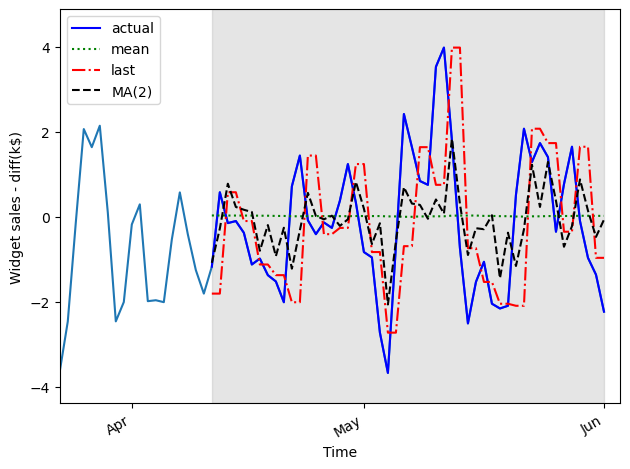

In [67]:
#Visualize our prediction
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff(k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])


fig.autofmt_xdate()
plt.tight_layout()



plt.show()

In [68]:
# Measure the performance of our model (MSE)
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497863145


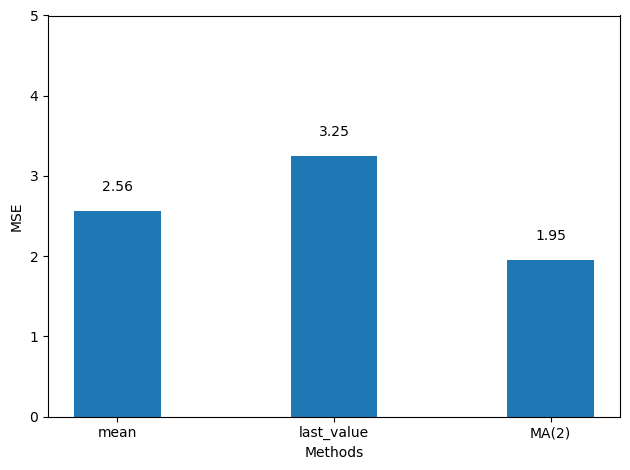

In [69]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.show()

In [70]:
# Inverse-transform our prediction
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

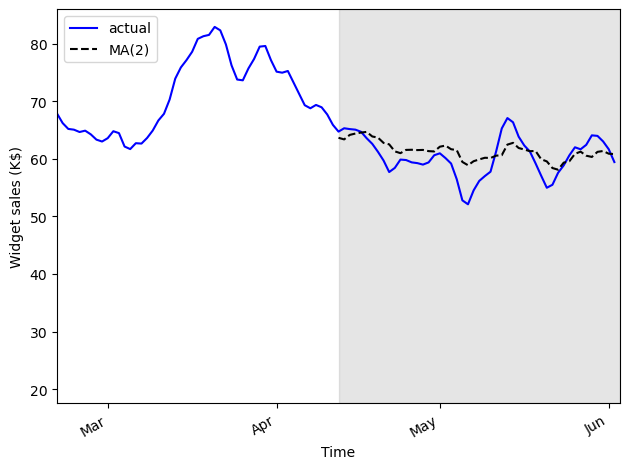

In [71]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [72]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

2.324470924451404
